In [1]:
%matplotlib inline
import warnings
import time
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from tqdm import tqdm_notebook, tqdm
import dill

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, precision_recall_curve, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

from prettytable import PrettyTable

In [2]:
#Pickle python objects to file
import pickle
def savetofile(obj,filename):
    pickle.dump(obj,open(filename+".p","wb"), protocol=4)
def openfromfile(filename):
    temp = pickle.load(open(filename+".p","rb"))
    return temp

In [3]:
X_train_bow_uni = openfromfile('bowuni-small')
X_test_bow_uni = openfromfile('bowuni_test-small')

X_train_bow_bi = openfromfile('bowbi-small')
X_test_bow_bi = openfromfile('bowbi_test-small')

X_train_tf_uni = openfromfile('tfidfuni-small')
X_test_tf_uni = openfromfile('tfidfuni_test-small')

X_train_tf_bi = openfromfile('tfidfbi-small')
X_test_tf_bi = openfromfile('tfidfbi_test-small')

X_train_pre_avg = openfromfile('pre-avg-w2v-small')
X_test_pre_avg = openfromfile('pre-avg-w2v_test-small')

X_train_pre_tf = openfromfile('pre-tfidf-w2v-small')
X_test_pre_tf = openfromfile('pre-tfidf-w2v_test-small')

X_train_own_avg = openfromfile('own-avg-w2v-small')
X_test_own_avg = openfromfile('own-avg-w2v_test-small')

X_train_own_tf = openfromfile('own-tfidf-w2v-small')
X_test__own_tf = openfromfile('own-tfidf-w2v_test-small')

y_train = openfromfile('y_train-small')
y_test = openfromfile('y_test-small')

## KNN

First algorithm we'll analyse on our Amazon FR dataset is K-Nearest Neighbor. We'll do hyperparameter tuning for K in KNN using GridSearchCV and train our model for optimal K.

In [4]:
myList = list(range(0,70))

In [5]:
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

### On Unigram BOWs

#### Using Euclidean Distance as a distance metric (default)

In [10]:
# Hyper-parameter tuning for K in K-NN
neigh = KNeighborsClassifier()

neighbors = list(filter(lambda x: x % 2 != 0, myList))
parameters = {'n_neighbors':neighbors}
clf = GridSearchCV(neigh, parameters, scoring='roc_auc', verbose=5, n_jobs=-1, return_train_score=True)
clf.fit(X_train_bow_uni, y_train)

Fitting 3 folds for each of 35 candidates, totalling 105 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 20.2min
[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed: 38.3min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=-1,
             param_grid={'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21,
                                         23, 25, 27, 29, 31, 33, 35, 37, 39, 41,
                                         43, 45, 47, 49, 51, 53, 55, 57, 59, ...]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=5)

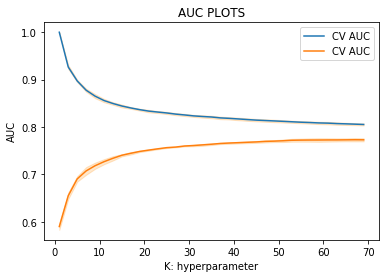

In [11]:
train_auc = clf.cv_results_['mean_train_score']
train_auc_std = clf.cv_results_['std_train_score']

cv_auc = clf.cv_results_['mean_test_score']
cv_auc_std= clf.cv_results_['std_test_score']

plt.plot(neighbors, train_auc, label='CV AUC')
plt.gca().fill_between(neighbors,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkorange')

plt.plot(neighbors, cv_auc, label='CV AUC')
plt.gca().fill_between(neighbors,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC PLOTS")
plt.show()

In [12]:
# extracting K for which our CV AUC is maximum
idx = np.where(cv_auc == cv_auc.max())

best_k = neighbors[idx[0][0]]
print('Our optimal K is: {}'.format(best_k))

Our optimal K is: 67


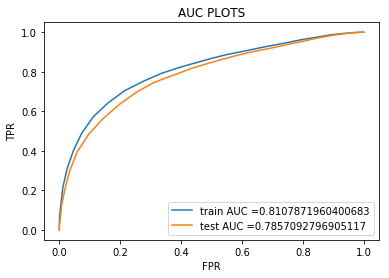

In [13]:
#Train our KNN model using our Training Dataset and optimal K found above

neigh = KNeighborsClassifier(n_neighbors=best_k, n_jobs=-1)
neigh.fit(X_train_bow_uni, y_train)

y_train_probs = neigh.predict_proba(X_train_bow_uni)[:,1]
y_test_probs = neigh.predict_proba(X_test_bow_uni)[:,1]

train_fpr, train_tpr, thresholds_tr = roc_curve(y_train, y_train_probs)
test_fpr, test_tpr, thresholds_tst = roc_curve(y_test, y_test_probs)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("AUC PLOTS")
plt.show()

We get a pretty high test AUC score of 0.78

the maximum value of tpr*(1-fpr) 0.5531793861717128 for threshold 0.866
Train confusion matrix


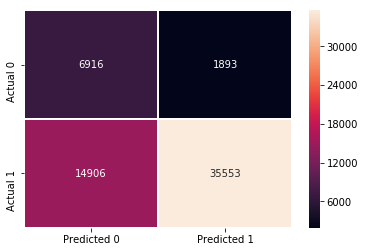

In [14]:
best_t_tr = find_best_threshold(thresholds_tr, train_fpr, train_tpr)
print("Train confusion matrix")
cnf_mat_tr = confusion_matrix(y_train, predict_with_best_t(y_train_probs, best_t_tr))
sns.heatmap(cnf_mat_tr, annot=True, fmt='g', linewidths=0.5, xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])

Test confusion matrix


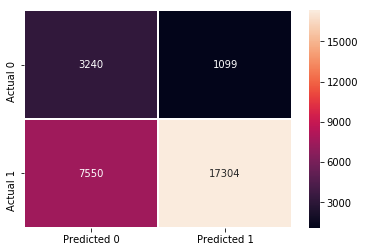

In [15]:
print("Test confusion matrix")
cnf_mat_test = confusion_matrix(y_test, predict_with_best_t(y_test_probs, best_t_tr))
sns.heatmap(cnf_mat_test, annot=True, fmt='g', linewidths=0.5, xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])

In [22]:
print('Accuracy of test data: {}'.format(accuracy_score(y_test, predict_with_best_t(y_test_probs, best_t_tr))))
print('Precision of test data: {}'.format(precision_score(y_test, predict_with_best_t(y_test_probs, best_t_tr))))
print('Recall of test data: {}'.format(recall_score(y_test, predict_with_best_t(y_test_probs, best_t_tr))))
print('F1-Score of test data: {}'.format(f1_score(y_test, predict_with_best_t(y_test_probs, best_t_tr))))

Accuracy of test data: 0.7037303463158976
Precision of test data: 0.9402814758463294
Recall of test data: 0.6962259596040878
F1-Score of test data: 0.8000554823496775


1. We can see that our test data has accuracy of 70% but as this is imbalanced data we cannot rely on it
2. Very high precision of 0.94 is found on test data. This fact can also be found from confusion matrix. 
3. If we adjust the threshold, probably we can increase recall a bit.
4. F1- Score of 0.80 is good.

#### Using Cosine Distance as a distance metric

In [7]:
# Hyper-parameter tuning for K in K-NN
neigh = KNeighborsClassifier(metric='cosine')

neighbors = list(filter(lambda x: x % 2 != 0, myList))
parameters = {'n_neighbors':neighbors}
clf = GridSearchCV(neigh, parameters, scoring='roc_auc', verbose=5, n_jobs=-1, return_train_score=True)
clf.fit(X_train_bow_uni, y_train)

Fitting 3 folds for each of 35 candidates, totalling 105 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 19.9min
[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed: 38.2min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='cosine', metric_params=None,
                                            n_jobs=None, n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=-1,
             param_grid={'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21,
                                         23, 25, 27, 29, 31, 33, 35, 37, 39, 41,
                                         43, 45, 47, 49, 51, 53, 55, 57, 59, ...]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=5)

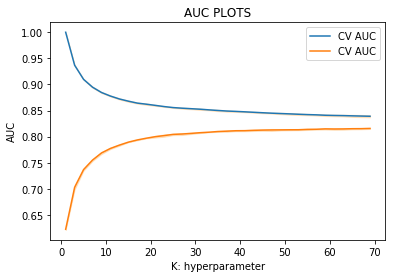

In [8]:
train_auc = clf.cv_results_['mean_train_score']
train_auc_std = clf.cv_results_['std_train_score']

cv_auc = clf.cv_results_['mean_test_score']
cv_auc_std= clf.cv_results_['std_test_score']

plt.plot(neighbors, train_auc, label='CV AUC')
plt.gca().fill_between(neighbors,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkorange')

plt.plot(neighbors, cv_auc, label='CV AUC')
plt.gca().fill_between(neighbors,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC PLOTS")
plt.show()

In [9]:
# extracting K for which our CV AUC is maximum
idx = np.where(cv_auc == cv_auc.max())

best_k = neighbors[idx[0][0]]
print('Our optimal K is: {}'.format(best_k))

Our optimal K is: 69


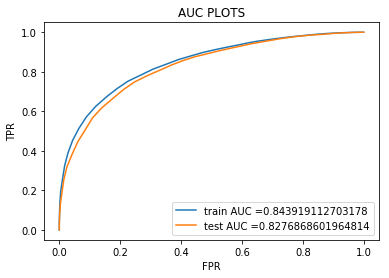

In [11]:
#Train our KNN model using our Training Dataset and optimal K found above

neigh = KNeighborsClassifier(n_neighbors=best_k, n_jobs=-1, metric='cosine')
neigh.fit(X_train_bow_uni, y_train)

y_train_probs = neigh.predict_proba(X_train_bow_uni)[:,1]
y_test_probs = neigh.predict_proba(X_test_bow_uni)[:,1]

train_fpr, train_tpr, thresholds_tr = roc_curve(y_train, y_train_probs)
test_fpr, test_tpr, thresholds_tst = roc_curve(y_test, y_test_probs)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("AUC PLOTS")
plt.show()

the maximum value of tpr*(1-fpr) 0.582604862523798 for threshold 0.812
Train confusion matrix


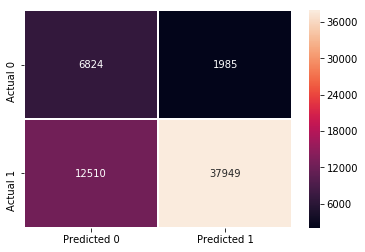

In [12]:
best_t_tr = find_best_threshold(thresholds_tr, train_fpr, train_tpr)
print("Train confusion matrix")
cnf_mat_tr = confusion_matrix(y_train, predict_with_best_t(y_train_probs, best_t_tr))
sns.heatmap(cnf_mat_tr, annot=True, fmt='g', linewidths=0.5, xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])

Test confusion matrix


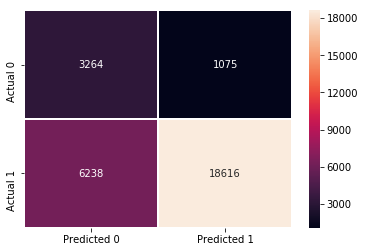

In [13]:
print("Test confusion matrix")
cnf_mat_test = confusion_matrix(y_test, predict_with_best_t(y_test_probs, best_t_tr))
sns.heatmap(cnf_mat_test, annot=True, fmt='g', linewidths=0.5, xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])

In [14]:
print('Accuracy of test data: {}'.format(accuracy_score(y_test, predict_with_best_t(y_test_probs, best_t_tr))))
print('Precision of test data: {}'.format(precision_score(y_test, predict_with_best_t(y_test_probs, best_t_tr))))
print('Recall of test data: {}'.format(recall_score(y_test, predict_with_best_t(y_test_probs, best_t_tr))))
print('F1-Score of test data: {}'.format(f1_score(y_test, predict_with_best_t(y_test_probs, best_t_tr))))

Accuracy of test data: 0.7494947418901792
Precision of test data: 0.9454065309024428
Recall of test data: 0.7490142431801722
F1-Score of test data: 0.8358289370299696


1. Better Precision
2. Better accuracy
3. better recall (on same better precision, that's something)
4. better F1-score
5. better test AUC score

It clearly shows us that using cosine distance as metric produces better results

### On Bigram BOWs

#### Using Euclidean Distance as a distance metric (default)

In [15]:
# Hyper-parameter tuning for K in K-NN
neigh = KNeighborsClassifier()

neighbors = list(filter(lambda x: x % 2 != 0, myList))
parameters = {'n_neighbors':neighbors}
clf = GridSearchCV(neigh, parameters, scoring='roc_auc', verbose=5, n_jobs=-1, return_train_score=True)
clf.fit(X_train_bow_bi, y_train)

Fitting 3 folds for each of 35 candidates, totalling 105 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 20.7min
[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed: 39.0min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=-1,
             param_grid={'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21,
                                         23, 25, 27, 29, 31, 33, 35, 37, 39, 41,
                                         43, 45, 47, 49, 51, 53, 55, 57, 59, ...]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=5)

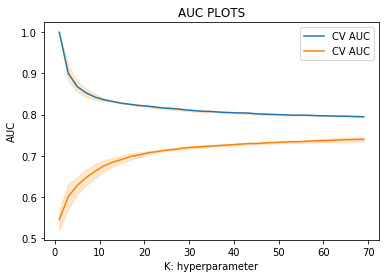

In [16]:
train_auc = clf.cv_results_['mean_train_score']
train_auc_std = clf.cv_results_['std_train_score']

cv_auc = clf.cv_results_['mean_test_score']
cv_auc_std= clf.cv_results_['std_test_score']

plt.plot(neighbors, train_auc, label='CV AUC')
plt.gca().fill_between(neighbors,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkorange')

plt.plot(neighbors, cv_auc, label='CV AUC')
plt.gca().fill_between(neighbors,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC PLOTS")
plt.show()

In [17]:
# extracting K for which our CV AUC is maximum
idx = np.where(cv_auc == cv_auc.max())

best_k = neighbors[idx[0][0]]
print('Our optimal K is: {}'.format(best_k))

Our optimal K is: 69


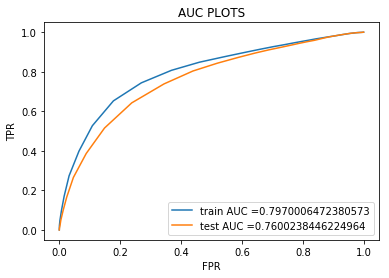

In [20]:
#Train our KNN model using our Training Dataset and optimal K found above

neigh = KNeighborsClassifier(n_neighbors=best_k, n_jobs=-1)
neigh.fit(X_train_bow_bi, y_train)

y_train_probs = neigh.predict_proba(X_train_bow_bi)[:,1]
y_test_probs = neigh.predict_proba(X_test_bow_bi)[:,1]

train_fpr, train_tpr, thresholds_tr = roc_curve(y_train, y_train_probs)
test_fpr, test_tpr, thresholds_tst = roc_curve(y_test, y_test_probs)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("AUC PLOTS")
plt.show()

the maximum value of tpr*(1-fpr) 0.5434604147075494 for threshold 0.855
Train confusion matrix


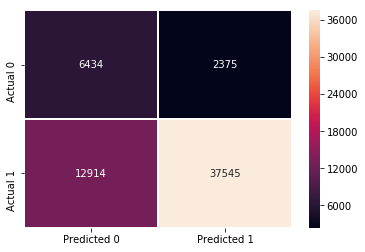

In [21]:
best_t_tr = find_best_threshold(thresholds_tr, train_fpr, train_tpr)
print("Train confusion matrix")
cnf_mat_tr = confusion_matrix(y_train, predict_with_best_t(y_train_probs, best_t_tr))
sns.heatmap(cnf_mat_tr, annot=True, fmt='g', linewidths=0.5, xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])

Test confusion matrix


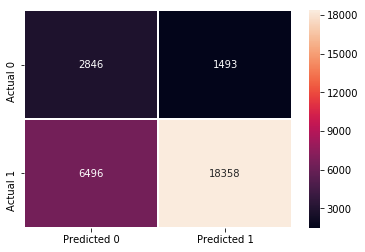

In [22]:
print("Test confusion matrix")
cnf_mat_test = confusion_matrix(y_test, predict_with_best_t(y_test_probs, best_t_tr))
sns.heatmap(cnf_mat_test, annot=True, fmt='g', linewidths=0.5, xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])

In [23]:
print('Accuracy of test data: {}'.format(accuracy_score(y_test, predict_with_best_t(y_test_probs, best_t_tr))))
print('Precision of test data: {}'.format(precision_score(y_test, predict_with_best_t(y_test_probs, best_t_tr))))
print('Recall of test data: {}'.format(recall_score(y_test, predict_with_best_t(y_test_probs, best_t_tr))))
print('F1-Score of test data: {}'.format(f1_score(y_test, predict_with_best_t(y_test_probs, best_t_tr))))

Accuracy of test data: 0.7263385058061864
Precision of test data: 0.9247896831393885
Recall of test data: 0.738633620342802
F1-Score of test data: 0.8212951571412596


1. Test AUC score has dropped from 0.785 for unigram bows to 0.760 for bigram bows
2. But even though test AUC score has gone down a bit, accuracy has increased from 70.7% to 72.6%
3. Precision has gone down by 0.02 but recall has increased by 0.4 so overall it's an improvement
4. F1-score has also increased

So even though we saw a slight decrease in test AUC for bigrams, other metrics show that it has actually performed better than unigrams.

#### Using Cosine Distance as a distance metric

In [24]:
# Hyper-parameter tuning for K in K-NN
neigh = KNeighborsClassifier(metric='cosine')

neighbors = list(filter(lambda x: x % 2 != 0, myList))
parameters = {'n_neighbors':neighbors}
clf = GridSearchCV(neigh, parameters, scoring='roc_auc', verbose=5, n_jobs=-1, return_train_score=True)
clf.fit(X_train_bow_bi, y_train)

Fitting 3 folds for each of 35 candidates, totalling 105 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 20.6min
[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed: 39.6min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='cosine', metric_params=None,
                                            n_jobs=None, n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=-1,
             param_grid={'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21,
                                         23, 25, 27, 29, 31, 33, 35, 37, 39, 41,
                                         43, 45, 47, 49, 51, 53, 55, 57, 59, ...]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=5)

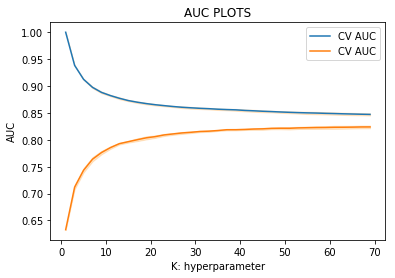

In [25]:
train_auc = clf.cv_results_['mean_train_score']
train_auc_std = clf.cv_results_['std_train_score']

cv_auc = clf.cv_results_['mean_test_score']
cv_auc_std= clf.cv_results_['std_test_score']

plt.plot(neighbors, train_auc, label='CV AUC')
plt.gca().fill_between(neighbors,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkorange')

plt.plot(neighbors, cv_auc, label='CV AUC')
plt.gca().fill_between(neighbors,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC PLOTS")
plt.show()

In [26]:
# extracting K for which our CV AUC is maximum
idx = np.where(cv_auc == cv_auc.max())

best_k = neighbors[idx[0][0]]
print('Our optimal K is: {}'.format(best_k))

Our optimal K is: 69


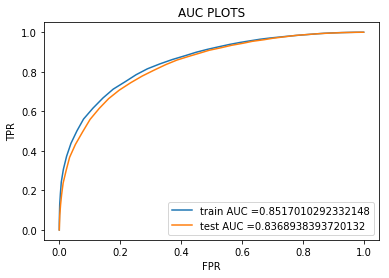

In [27]:
#Train our KNN model using our Training Dataset and optimal K found above

neigh = KNeighborsClassifier(n_neighbors=best_k, n_jobs=-1, metric='cosine')
neigh.fit(X_train_bow_bi, y_train)

y_train_probs = neigh.predict_proba(X_train_bow_bi)[:,1]
y_test_probs = neigh.predict_proba(X_test_bow_bi)[:,1]

train_fpr, train_tpr, thresholds_tr = roc_curve(y_train, y_train_probs)
test_fpr, test_tpr, thresholds_tst = roc_curve(y_test, y_test_probs)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("AUC PLOTS")
plt.show()

the maximum value of tpr*(1-fpr) 0.5873948623989592 for threshold 0.812
Train confusion matrix


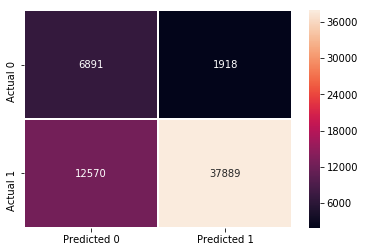

In [28]:
best_t_tr = find_best_threshold(thresholds_tr, train_fpr, train_tpr)
print("Train confusion matrix")
cnf_mat_tr = confusion_matrix(y_train, predict_with_best_t(y_train_probs, best_t_tr))
sns.heatmap(cnf_mat_tr, annot=True, fmt='g', linewidths=0.5, xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])

Test confusion matrix


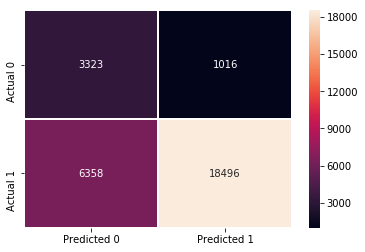

In [29]:
print("Test confusion matrix")
cnf_mat_test = confusion_matrix(y_test, predict_with_best_t(y_test_probs, best_t_tr))
sns.heatmap(cnf_mat_test, annot=True, fmt='g', linewidths=0.5, xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])

In [30]:
print('Accuracy of test data: {}'.format(accuracy_score(y_test, predict_with_best_t(y_test_probs, best_t_tr))))
print('Precision of test data: {}'.format(precision_score(y_test, predict_with_best_t(y_test_probs, best_t_tr))))
print('Recall of test data: {}'.format(recall_score(y_test, predict_with_best_t(y_test_probs, best_t_tr))))
print('F1-Score of test data: {}'.format(f1_score(y_test, predict_with_best_t(y_test_probs, best_t_tr))))

Accuracy of test data: 0.7474051998766827
Precision of test data: 0.947929479294793
Recall of test data: 0.7441860465116279
F1-Score of test data: 0.8337916422485688


### Summary of BOWs

In [32]:
x = PrettyTable()

x.field_names = ["Representation", "Metric", "Hyper-parameter", "Test AUC", "Accuracy", "Precision", "Recall", "F1-Score"]

In [33]:
x.add_row(["Unigram BOWs", "Euclidean", 67, 0.785, 0.703, 0.940, 0.696, 0.800])
x.add_row(["Unigram BOWs", "Cosine", 69, 0.827, 0.749, 0.945, 0.749, 0.835])

x.add_row(["Bigram BOWs", "Euclidean", 69, 0.760, 0.726, 0.924, 0.738, 0.821])
x.add_row(["Bigram BOWs", "Cosine", 69, 0.836, 0.747, 0.947, 0.747, 0.833])

In [39]:
print(x)

+----------------+-----------+-----------------+----------+----------+-----------+--------+----------+
| Representation |   Metric  | Hyper-parameter | Test AUC | Accuracy | Precision | Recall | F1-Score |
+----------------+-----------+-----------------+----------+----------+-----------+--------+----------+
|  Unigram BOWs  | Euclidean |        67       |  0.785   |  0.703   |    0.94   | 0.696  |   0.8    |
|  Unigram BOWs  |   Cosine  |        69       |  0.827   |  0.749   |   0.945   | 0.749  |  0.835   |
|  Bigram BOWs   | Euclidean |        69       |   0.76   |  0.726   |   0.924   | 0.738  |  0.821   |
|  Bigram BOWs   |   Cosine  |        69       |  0.836   |  0.747   |   0.947   | 0.747  |  0.833   |
+----------------+-----------+-----------------+----------+----------+-----------+--------+----------+


<b>
1. Cosine metric has proved to be a better metric than euclidean distance. <br>
2. Using Bigrams have given has very little improvement (not much). We can take a call whether to use unigram or bigram to save space. 
</b>

### On Unigram TF-IDF

#### Using Euclidean Distance as a distance metric (deafult)

In [6]:
# Hyper-parameter tuning for K in K-NN
neigh = KNeighborsClassifier()

neighbors = list(filter(lambda x: x % 2 != 0, myList))
parameters = {'n_neighbors':neighbors}
clf = GridSearchCV(neigh, parameters, scoring='roc_auc', verbose=5, n_jobs=-1, return_train_score=True)
clf.fit(X_train_tf_uni, y_train)

Fitting 3 folds for each of 35 candidates, totalling 105 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 20.1min
[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed: 38.6min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=-1,
             param_grid={'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21,
                                         23, 25, 27, 29, 31, 33, 35, 37, 39, 41,
                                         43, 45, 47, 49, 51, 53, 55, 57, 59, ...]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=5)

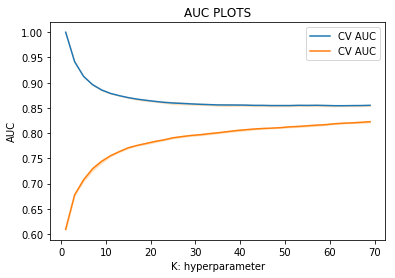

In [8]:
train_auc = clf.cv_results_['mean_train_score']
train_auc_std = clf.cv_results_['std_train_score']

cv_auc = clf.cv_results_['mean_test_score']
cv_auc_std= clf.cv_results_['std_test_score']

plt.plot(neighbors, train_auc, label='CV AUC')
plt.gca().fill_between(neighbors,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkorange')

plt.plot(neighbors, cv_auc, label='CV AUC')
plt.gca().fill_between(neighbors,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC PLOTS")
plt.show()

In [9]:
# extracting K for which our CV AUC is maximum
idx = np.where(cv_auc == cv_auc.max())

best_k = neighbors[idx[0][0]]
print('Our optimal K is: {}'.format(best_k))

Our optimal K is: 69


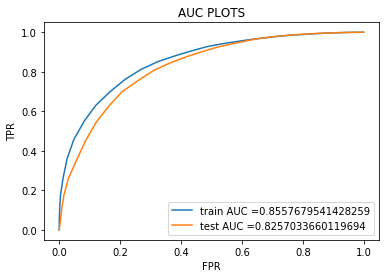

In [23]:
#Train our KNN model using our Training Dataset and optimal K found above

neigh = KNeighborsClassifier(n_neighbors=best_k, n_jobs=-1)
neigh.fit(X_train_tf_uni, y_train)

y_train_probs = neigh.predict_proba(X_train_tf_uni)[:,1]
y_test_probs = neigh.predict_proba(X_test_tf_uni)[:,1]

train_fpr, train_tpr, thresholds_tr = roc_curve(y_train, y_train_probs)
test_fpr, test_tpr, thresholds_tst = roc_curve(y_test, y_test_probs)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("AUC PLOTS")
plt.show()

the maximum value of tpr*(1-fpr) 0.5968060069724647 for threshold 0.855
Train confusion matrix


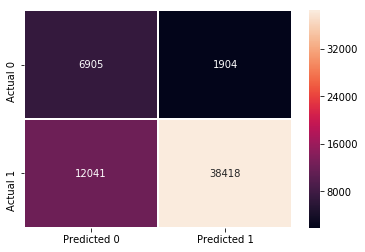

In [24]:
best_t_tr = find_best_threshold(thresholds_tr, train_fpr, train_tpr)
print("Train confusion matrix")
cnf_mat_tr = confusion_matrix(y_train, predict_with_best_t(y_train_probs, best_t_tr))
sns.heatmap(cnf_mat_tr, annot=True, fmt='g', linewidths=0.5, xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])

Test confusion matrix


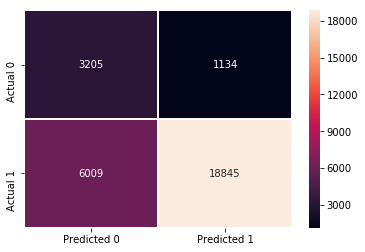

In [25]:
print("Test confusion matrix")
cnf_mat_test = confusion_matrix(y_test, predict_with_best_t(y_test_probs, best_t_tr))
sns.heatmap(cnf_mat_test, annot=True, fmt='g', linewidths=0.5, xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])

In [26]:
print('Accuracy of test data: {}'.format(accuracy_score(y_test, predict_with_best_t(y_test_probs, best_t_tr))))
print('Precision of test data: {}'.format(precision_score(y_test, predict_with_best_t(y_test_probs, best_t_tr))))
print('Recall of test data: {}'.format(recall_score(y_test, predict_with_best_t(y_test_probs, best_t_tr))))
print('F1-Score of test data: {}'.format(f1_score(y_test, predict_with_best_t(y_test_probs, best_t_tr))))

Accuracy of test data: 0.7553180556982838
Precision of test data: 0.9432404024225437
Recall of test data: 0.7582280518226442
F1-Score of test data: 0.8406753953560993


#### Using Cosine Distance as a distance metric

In [16]:
# Hyper-parameter tuning for K in K-NN
neigh = KNeighborsClassifier(metric='cosine')

neighbors = list(filter(lambda x: x % 2 != 0, myList))
parameters = {'n_neighbors':neighbors}
clf = GridSearchCV(neigh, parameters, scoring='roc_auc', verbose=5, n_jobs=-1, return_train_score=True)
clf.fit(X_train_tf_uni, y_train)

Fitting 3 folds for each of 35 candidates, totalling 105 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 19.5min
[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed: 37.7min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='cosine', metric_params=None,
                                            n_jobs=None, n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=-1,
             param_grid={'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21,
                                         23, 25, 27, 29, 31, 33, 35, 37, 39, 41,
                                         43, 45, 47, 49, 51, 53, 55, 57, 59, ...]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=5)

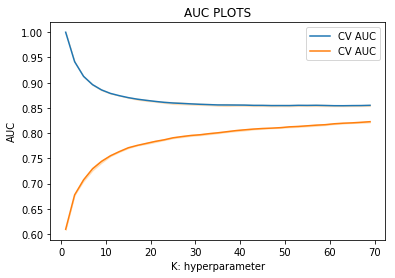

In [17]:
train_auc = clf.cv_results_['mean_train_score']
train_auc_std = clf.cv_results_['std_train_score']

cv_auc = clf.cv_results_['mean_test_score']
cv_auc_std= clf.cv_results_['std_test_score']

plt.plot(neighbors, train_auc, label='CV AUC')
plt.gca().fill_between(neighbors,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkorange')

plt.plot(neighbors, cv_auc, label='CV AUC')
plt.gca().fill_between(neighbors,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC PLOTS")
plt.show()

In [18]:
# extracting K for which our CV AUC is maximum
idx = np.where(cv_auc == cv_auc.max())

best_k = neighbors[idx[0][0]]
print('Our optimal K is: {}'.format(best_k))

Our optimal K is: 69


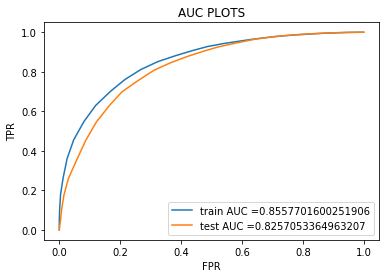

In [28]:
#Train our KNN model using our Training Dataset and optimal K found above

neigh = KNeighborsClassifier(n_neighbors=best_k, n_jobs=-1, metric='cosine')
neigh.fit(X_train_tf_uni, y_train)
y_train_probs = neigh.predict_proba(X_train_tf_uni)[:,1]
y_test_probs = neigh.predict_proba(X_test_tf_uni)[:,1]

train_fpr, train_tpr, thresholds_tr = roc_curve(y_train, y_train_probs)
test_fpr, test_tpr, thresholds_tst = roc_curve(y_test, y_test_probs)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("AUC PLOTS")
plt.show()

the maximum value of tpr*(1-fpr) 0.5968060069724647 for threshold 0.855
Train confusion matrix


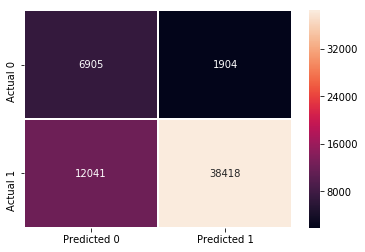

In [29]:
best_t_tr = find_best_threshold(thresholds_tr, train_fpr, train_tpr)
print("Train confusion matrix")
cnf_mat_tr = confusion_matrix(y_train, predict_with_best_t(y_train_probs, best_t_tr))
sns.heatmap(cnf_mat_tr, annot=True, fmt='g', linewidths=0.5, xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])

Test confusion matrix


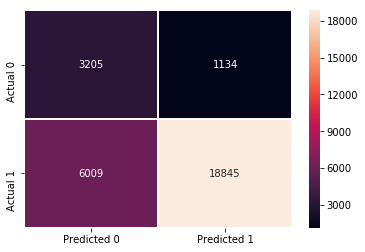

In [30]:
print("Test confusion matrix")
cnf_mat_test = confusion_matrix(y_test, predict_with_best_t(y_test_probs, best_t_tr))
sns.heatmap(cnf_mat_test, annot=True, fmt='g', linewidths=0.5, xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])

In [31]:
print('Accuracy of test data: {}'.format(accuracy_score(y_test, predict_with_best_t(y_test_probs, best_t_tr))))
print('Precision of test data: {}'.format(precision_score(y_test, predict_with_best_t(y_test_probs, best_t_tr))))
print('Recall of test data: {}'.format(recall_score(y_test, predict_with_best_t(y_test_probs, best_t_tr))))
print('F1-Score of test data: {}'.format(f1_score(y_test, predict_with_best_t(y_test_probs, best_t_tr))))

Accuracy of test data: 0.7553180556982838
Precision of test data: 0.9432404024225437
Recall of test data: 0.7582280518226442
F1-Score of test data: 0.8406753953560993


1. TF-IDF working better than BOWs
2. unigram TF-IDF giving same results for both metrics. Strange!

### On Bigram TF-IDF

#### Using Euclidean Distance as a distance metric (default)

In [32]:
# Hyper-parameter tuning for K in K-NN
neigh = KNeighborsClassifier()

neighbors = list(filter(lambda x: x % 2 != 0, myList))
parameters = {'n_neighbors':neighbors}
clf = GridSearchCV(neigh, parameters, scoring='roc_auc', verbose=5, n_jobs=-1, return_train_score=True)
clf.fit(X_train_tf_bi, y_train)

Fitting 3 folds for each of 35 candidates, totalling 105 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 20.6min
[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed: 40.0min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=-1,
             param_grid={'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21,
                                         23, 25, 27, 29, 31, 33, 35, 37, 39, 41,
                                         43, 45, 47, 49, 51, 53, 55, 57, 59, ...]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=5)

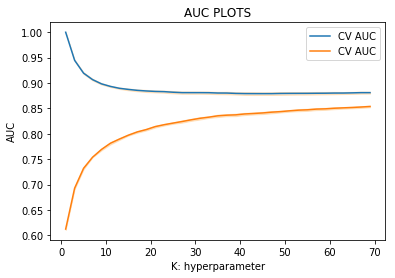

In [33]:
train_auc = clf.cv_results_['mean_train_score']
train_auc_std = clf.cv_results_['std_train_score']

cv_auc = clf.cv_results_['mean_test_score']
cv_auc_std= clf.cv_results_['std_test_score']

plt.plot(neighbors, train_auc, label='CV AUC')
plt.gca().fill_between(neighbors,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkorange')

plt.plot(neighbors, cv_auc, label='CV AUC')
plt.gca().fill_between(neighbors,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC PLOTS")
plt.show()

In [34]:
# extracting K for which our CV AUC is maximum
idx = np.where(cv_auc == cv_auc.max())

best_k = neighbors[idx[0][0]]
print('Our optimal K is: {}'.format(best_k))

Our optimal K is: 69


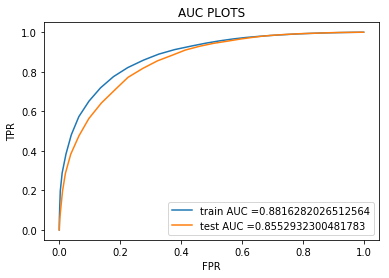

In [35]:
#Train our KNN model using our Training Dataset and optimal K found above

neigh = KNeighborsClassifier(n_neighbors=best_k, n_jobs=-1)
neigh.fit(X_train_tf_bi, y_train)
y_train_probs = neigh.predict_proba(X_train_tf_bi)[:,1]
y_test_probs = neigh.predict_proba(X_test_tf_bi)[:,1]

train_fpr, train_tpr, thresholds_tr = roc_curve(y_train, y_train_probs)
test_fpr, test_tpr, thresholds_tst = roc_curve(y_test, y_test_probs)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("AUC PLOTS")
plt.show()

the maximum value of tpr*(1-fpr) 0.6374227468443164 for threshold 0.855
Train confusion matrix


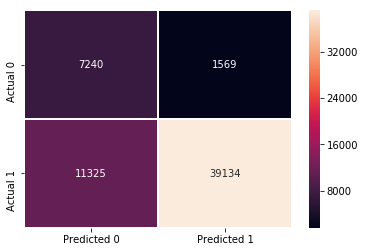

In [36]:
best_t_tr = find_best_threshold(thresholds_tr, train_fpr, train_tpr)
print("Train confusion matrix")
cnf_mat_tr = confusion_matrix(y_train, predict_with_best_t(y_train_probs, best_t_tr))
sns.heatmap(cnf_mat_tr, annot=True, fmt='g', linewidths=0.5, xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])

Test confusion matrix


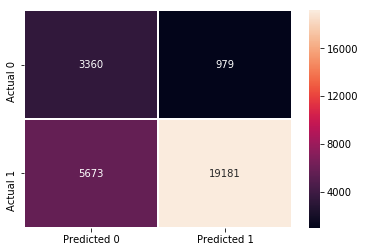

In [37]:
print("Test confusion matrix")
cnf_mat_test = confusion_matrix(y_test, predict_with_best_t(y_test_probs, best_t_tr))
sns.heatmap(cnf_mat_test, annot=True, fmt='g', linewidths=0.5, xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])

In [38]:
print('Accuracy of test data: {}'.format(accuracy_score(y_test, predict_with_best_t(y_test_probs, best_t_tr))))
print('Precision of test data: {}'.format(precision_score(y_test, predict_with_best_t(y_test_probs, best_t_tr))))
print('Recall of test data: {}'.format(recall_score(y_test, predict_with_best_t(y_test_probs, best_t_tr))))
print('F1-Score of test data: {}'.format(f1_score(y_test, predict_with_best_t(y_test_probs, best_t_tr))))

Accuracy of test data: 0.7721371561675744
Precision of test data: 0.9514384920634921
Recall of test data: 0.7717470024945683
F1-Score of test data: 0.852223752610299


#### Using Cosine Distance as a distance metric

In [39]:
# Hyper-parameter tuning for K in K-NN
neigh = KNeighborsClassifier(metric='cosine')

neighbors = list(filter(lambda x: x % 2 != 0, myList))
parameters = {'n_neighbors':neighbors}
clf = GridSearchCV(neigh, parameters, scoring='roc_auc', verbose=5, n_jobs=-1, return_train_score=True)
clf.fit(X_train_tf_bi, y_train)

Fitting 3 folds for each of 35 candidates, totalling 105 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 20.4min
[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed: 39.1min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='cosine', metric_params=None,
                                            n_jobs=None, n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=-1,
             param_grid={'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21,
                                         23, 25, 27, 29, 31, 33, 35, 37, 39, 41,
                                         43, 45, 47, 49, 51, 53, 55, 57, 59, ...]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=5)

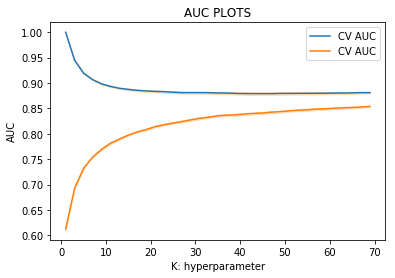

In [40]:
train_auc = clf.cv_results_['mean_train_score']
train_auc_std = clf.cv_results_['std_train_score']

cv_auc = clf.cv_results_['mean_test_score']
cv_auc_std= clf.cv_results_['std_test_score']

plt.plot(neighbors, train_auc, label='CV AUC')
plt.gca().fill_between(neighbors,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkorange')

plt.plot(neighbors, cv_auc, label='CV AUC')
plt.gca().fill_between(neighbors,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC PLOTS")
plt.show()

In [41]:
# extracting K for which our CV AUC is maximum
idx = np.where(cv_auc == cv_auc.max())

best_k = neighbors[idx[0][0]]
print('Our optimal K is: {}'.format(best_k))

Our optimal K is: 69


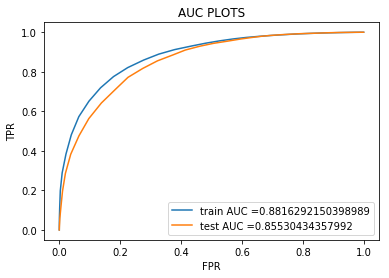

In [42]:
#Train our KNN model using our Training Dataset and optimal K found above

neigh = KNeighborsClassifier(n_neighbors=best_k, n_jobs=-1, metric='cosine')
neigh.fit(X_train_tf_bi, y_train)
y_train_probs = neigh.predict_proba(X_train_tf_bi)[:,1]
y_test_probs = neigh.predict_proba(X_test_tf_bi)[:,1]

train_fpr, train_tpr, thresholds_tr = roc_curve(y_train, y_train_probs)
test_fpr, test_tpr, thresholds_tst = roc_curve(y_test, y_test_probs)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("AUC PLOTS")
plt.show()

the maximum value of tpr*(1-fpr) 0.6374227468443164 for threshold 0.855
Train confusion matrix


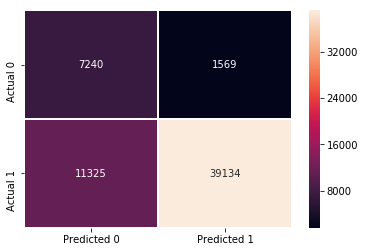

In [43]:
best_t_tr = find_best_threshold(thresholds_tr, train_fpr, train_tpr)
print("Train confusion matrix")
cnf_mat_tr = confusion_matrix(y_train, predict_with_best_t(y_train_probs, best_t_tr))
sns.heatmap(cnf_mat_tr, annot=True, fmt='g', linewidths=0.5, xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])

Test confusion matrix


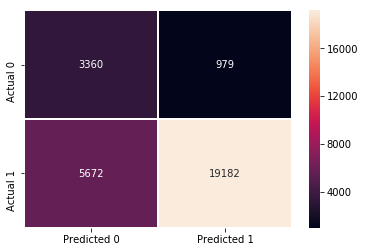

In [44]:
print("Test confusion matrix")
cnf_mat_test = confusion_matrix(y_test, predict_with_best_t(y_test_probs, best_t_tr))
sns.heatmap(cnf_mat_test, annot=True, fmt='g', linewidths=0.5, xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])

In [45]:
print('Accuracy of test data: {}'.format(accuracy_score(y_test, predict_with_best_t(y_test_probs, best_t_tr))))
print('Precision of test data: {}'.format(precision_score(y_test, predict_with_best_t(y_test_probs, best_t_tr))))
print('Recall of test data: {}'.format(recall_score(y_test, predict_with_best_t(y_test_probs, best_t_tr))))
print('F1-Score of test data: {}'.format(f1_score(y_test, predict_with_best_t(y_test_probs, best_t_tr))))

Accuracy of test data: 0.7721714109546809
Precision of test data: 0.9514409007489708
Recall of test data: 0.7717872374668061
F1-Score of test data: 0.8522492502499167


### Summary of TF-IDF

In [4]:
x = PrettyTable()

x.field_names = ["Representation", "Metric", "Hyper-parameter", "Test AUC", "Accuracy", "Precision", "Recall", "F1-Score"]

In [5]:
x.add_row(["Unigram BOWs", "Euclidean", 67, 0.785, 0.703, 0.940, 0.696, 0.800])
x.add_row(["Unigram BOWs", "Cosine", 69, 0.827, 0.749, 0.945, 0.749, 0.835])

x.add_row(["Bigram BOWs", "Euclidean", 69, 0.760, 0.726, 0.924, 0.738, 0.821])
x.add_row(["Bigram BOWs", "Cosine", 69, 0.836, 0.747, 0.947, 0.747, 0.833])

x.add_row(["Unigram TF-IDF", "Euclidean", 69, 0.825, 0.755, 0.943, 0.758, 0.840])
x.add_row(["Unigram BOWs", "Cosine", 69, 0.825, 0.755, 0.943, 0.758, 0.840])

x.add_row(["Bigram BOWs", "Euclidean", 69, 0.855, 0.772, 0.954, 0.771, 0.852])
x.add_row(["Bigram BOWs", "Cosine", 69, 0.855, 0.772, 0.951, 0.771, 0.852])

In [6]:
print(x)

+----------------+-----------+-----------------+----------+----------+-----------+--------+----------+
| Representation |   Metric  | Hyper-parameter | Test AUC | Accuracy | Precision | Recall | F1-Score |
+----------------+-----------+-----------------+----------+----------+-----------+--------+----------+
|  Unigram BOWs  | Euclidean |        67       |  0.785   |  0.703   |    0.94   | 0.696  |   0.8    |
|  Unigram BOWs  |   Cosine  |        69       |  0.827   |  0.749   |   0.945   | 0.749  |  0.835   |
|  Bigram BOWs   | Euclidean |        69       |   0.76   |  0.726   |   0.924   | 0.738  |  0.821   |
|  Bigram BOWs   |   Cosine  |        69       |  0.836   |  0.747   |   0.947   | 0.747  |  0.833   |
| Unigram TF-IDF | Euclidean |        69       |  0.825   |  0.755   |   0.943   | 0.758  |   0.84   |
|  Unigram BOWs  |   Cosine  |        69       |  0.825   |  0.755   |   0.943   | 0.758  |   0.84   |
|  Bigram BOWs   | Euclidean |        69       |  0.855   |  0.772   |   

Analysis:
1. TF-IDF gives better results than BOWs
2. Bigram TF-IDF is just slightly better than Unigram TF-IDF. We can skip using Bigram version to save space.
3. We have tested on odd values of K between 1-70 for hyperparameter tuning, we got the value of 69 in almost very case. This shows that we can test further values for better results.
4. Cosine and euclidean metrics for TF-IDF gives same results!